In [1]:
from __future__ import print_function
%matplotlib inline
import geopandas as gpd
import numpy as np
import pylab as pl
import pandas as pd
import io
import shapely
from geopandas.tools import sjoin
from geopandas import GeoDataFrame
from matplotlib import pyplot as plt
import pylab
import os
import zipfile
import json
from fiona.crs import from_epsg
import sys
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import requests
import choroplethNYC as cp
import pysal as ps
!pip install requests


/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_f

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Read in Data

I am working on a project for the NYS DOH looking at MediCaid Data, specifically at the proportion of Males to Females that file claims for the preventative drug called PreP for those at risk of prevention of HIV/AIDS 

In [2]:
#Set the environmental variable PUIDATA
puidata = os.getenv("PUIDATA")
if not puidata or puidata == '/nfshome/sjs909/PUIdata':
    puidata = '/nfshome/sjs909/PUIDATA'

os.environ["PUIDATA"] = puidata
os.environ["PUIDATA"]

'/nfshome/sjs909/PUIDATA'

## Dataset from DOH for distribution of male and female that filed claims, by county

In [3]:
CTYGender = pd.read_excel('%s/datawithCTYandGender.xlsx'%os.getenv("PUIDATA"))

In [5]:
CTYGender.head()

,county code,county,F,M
0,1,ALBANY,10,27
1,2,ALLEGANY,1,3
2,3,BROOME,4,15
3,4,CATTARAUGUS,2,1
4,5,CAYUGA,1,12


### generate a feature for the proportion of females to males

In [4]:
CTYGender['Fproportion'] =  CTYGender['F']/(CTYGender['F']+CTYGender['M'])

## Counties with Demographics, New York State, 2000
This dataset presents boundaries and basic demographic data from the 2000 Census for each county and county-equivalent area in New York state. For county-scale geographic and demographic analysis.

https://cugir.library.cornell.edu/catalog/cugir-007865

In [7]:
#with zipfile.ZipFile("%s/cugir-007865.zip"%os.getenv("PUIDATA")) as zip_ref:
#    zip_ref.extractall("NYSdir")

In [8]:
#Move into PUIDATA
#os.rename("/nfshome/sjs909/PUI2018/HW8_sjs909/NYSdir", "/nfshome/sjs909/PUIDATA/NYSdir")

In [5]:
NYSShape = gpd.GeoDataFrame.from_file('%s/NYSdir/cugir-007865'%os.getenv("PUIDATA"))

In [10]:
NYSShape.columns

Index([     u'STATE',     u'COUNTY',       u'NAME',       u'LSAD',
       u'LSAD_TRANS',       u'OID_', u'COUNTY_FIP',    u'POP2000',
            u'WHITE',      u'BLACK',    u'AMER_ES',      u'ASIAN',
          u'HAWN_PI',      u'OTHER',  u'MULT_RACE',   u'HISPANIC',
             u'MALE',     u'FEMALE',   u'M_UNDER5',       u'M5_9',
           u'M10_14',     u'M15_17',     u'M18_19',        u'M20',
              u'M21',     u'M22_24',     u'M25_29',     u'M30_34',
           u'M35_39',     u'M40_44',     u'M45_49',     u'M50_54',
           u'M55_59',     u'M60_61',     u'M62_64',     u'M65_66',
           u'M67_69',     u'M70_74',     u'M75_79',     u'M80_84',
         u'M_OVER85',   u'F_UNDER5',       u'F5_9',     u'F10_14',
           u'F15_17',     u'F18_19',        u'F20',        u'F21',
           u'F22_24',     u'F25_29',     u'F30_34',     u'F35_39',
           u'F40_44',     u'F45_49',     u'F50_54',     u'F55_59',
           u'F60_61',     u'F62_64',     u'F65_66',     u'F67_

In [11]:
len(np.unique(NYSShape['NAME']))

62

In [12]:
NYSShape.head()

,STATE,COUNTY,NAME,LSAD,LSAD_TRANS,OID_,COUNTY_FIP,POP2000,WHITE,BLACK,...,FHH_MINORC,FAMILIES,AV_FAM_SZ,HSE_UNITS,URBAN,RURAL,VACANT,OWNER_OCC,RENTER_OCC,geometry
0,36,089,St. Lawrence,06,County,44,089,111931,105782,2664,...,2773,26939,3,49721,16085,33636,9215,28606,11900,"POLYGON ((-74.712396 44.953008, -74.7111320000..."
1,36,019,Clinton,06,County,9,019,79894,74562,2863,...,1951,19261,3,33091,12161,20930,3668,20157,9266,"POLYGON ((-74.025026 44.980036, -74.0274011055..."
2,36,033,Franklin,06,County,16,033,51134,42970,3389,...,1312,11805,3,23936,7409,16527,6005,12638,5293,"POLYGON ((-74.025026 44.980036, -74.021078 44...."
3,36,031,Essex,06,County,15,031,38851,36848,1092,...,810,9832,3,23115,4288,18827,8087,11089,3939,"POLYGON ((-73.46411999999999 44.5354, -73.4649..."
4,36,045,Jefferson,06,County,22,045,111738,99118,6517,...,2815,28142,3,54070,20947,33123,14002,23906,16162,POLYGON ((-75.86007064557869 44.40327395405457...


## A more robust dataset from the DOH

In [6]:
PreP = pd.read_csv('%s/prep_pivots_10302018.csv'%os.getenv("PUIDATA"))

In [14]:
PreP.head()

,exclusion_flag,medicaid_flag,HIVdx_flag,RXarv_flag,HBVdx_flag,RXhbv_flag,gender,age_group,ethnicity_group,patient_zip3,county,patients
0,0,0,0,0,0,0,F,13-19,CAUCASIAN,ZZZ,NaN,1
1,0,0,0,0,0,0,F,13-19,OTHER/MISSING/UNKNOWN,10,Bronx/New York/Orange/Putnam/Richmond/Rockland...,1
2,0,0,0,0,0,0,F,13-19,OTHER/MISSING/UNKNOWN,11,Kings/Nassau/Queens/Suffolk,1
3,0,0,0,0,0,0,F,13-19,OTHER/MISSING/UNKNOWN,114,Queens,1
4,0,0,0,0,0,0,F,13-19,OTHER/MISSING/UNKNOWN,115,Nassau,1


# Merge all of three datasets by county


In [15]:
len(np.unique(PreP['county']))

273

In [16]:
# Fix capitalization issues, make everything all upper case

In [7]:
PreP['county'] = PreP['county'].str.upper()

In [8]:
NYSShape['NAME'] = NYSShape['NAME'].str.upper()

In [9]:
NYCShapeData = NYSShape.merge(PreP, left_on="NAME",right_on='county', how='outer')

In [10]:
NYCShapeData.head()

,STATE,COUNTY,NAME,LSAD,LSAD_TRANS,OID_,COUNTY_FIP,POP2000,WHITE,BLACK,...,HIVdx_flag,RXarv_flag,HBVdx_flag,RXhbv_flag,gender,age_group,ethnicity_group,patient_zip3,county,patients
0,36,089,ST. LAWRENCE,06,County,44.0,089,111931.0,105782.0,2664.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36,019,CLINTON,06,County,9.0,019,79894.0,74562.0,2863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36,033,FRANKLIN,06,County,16.0,033,51134.0,42970.0,3389.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36,031,ESSEX,06,County,15.0,031,38851.0,36848.0,1092.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,045,JEFFERSON,06,County,22.0,045,111738.0,99118.0,6517.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
len(np.unique(NYCShapeData['NAME']))

2720

In [22]:
# merge it with the small dataset too!

In [11]:
NYCShapeData = NYCShapeData.merge(CTYGender, left_on="NAME",right_on='county', how='outer')

In [13]:
NYCP = NYCShapeData[NYCShapeData['geometry'].notnull()]

# Let's Explore The Counties with Highest Female Proportion - Fulton and Schoharie

In [14]:
Fulton = NYCP.loc[NYCP['NAME'] == 'FULTON']
Schoharie = NYCP.loc[NYCP['NAME'] == 'SCHOHARIE']

In [15]:
HighF = pd.concat([Fulton, Schoharie], axis=0, sort=False)

In [16]:
races = ('WHITE','BLACK',         u'AMER_ES',           u'ASIAN',
               u'HAWN_PI',           u'OTHER',       u'MULT_RACE',
              u'HISPANIC')

In [17]:
# Make proportion of Race Population for Fulton
mylist = []
for i in range(len(races)):
    print(races[i])
    print((HighF.iloc[0][races[i]])/HighF.iloc[0]['POP2000'])
    mylist.append((HighF.iloc[0][races[i]])/HighF.iloc[0]['POP2000'])

Fulton['WhitePop'] = mylist[0]

Fulton['BlackPop'] = mylist[1]
Fulton['Amer_esPop'] = mylist[2]
Fulton['AsianPop'] = mylist[3]
Fulton['HawaiPop'] = mylist[4]
Fulton['OtherPop'] = mylist[5]
Fulton['MultiPop'] = mylist[6]
Fulton['HispanicPop'] = mylist[7]

WHITE
0.9598714433569989
BLACK
0.018012456194505474
AMER_ES
0.001906560383491003
ASIAN
0.005320211355836798
HAWN_PI
0.00016341946144208595
OTHER
0.005592577124906942
MULT_RACE
0.009133332122818805
HISPANIC
0.016051422657200443


/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [18]:
# Make proportion of Race Population for Schoharie

mylist = []
for i in range(len(races)):
    print(races[i])
    print((HighF.iloc[1][races[i]])/HighF.iloc[1]['POP2000'])
    mylist.append((HighF.iloc[1][races[i]])/HighF.iloc[1]['POP2000'])

Schoharie['WhitePop'] = mylist[0]
Schoharie['BlackPop'] = mylist[1]
Schoharie['Amer_esPop'] = mylist[2]
Schoharie['AsianPop'] = mylist[3]
Schoharie['HawaiPop'] = mylist[4]
Schoharie['OtherPop'] = mylist[5]
Schoharie['MultiPop'] = mylist[6]
Schoharie['HispanicPop'] = mylist[7]

WHITE
0.9661832689506681
BLACK
0.012760433158128047
AMER_ES
0.003039706161737699
ASIAN
0.0037996327021721232
HAWN_PI
0.00022164524096004052
OTHER
0.0047178772718637196
MULT_RACE
0.009277436514470268
HISPANIC
0.018618200240643406


/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/nfshome/sjs909/.conda/envs/myEnv/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

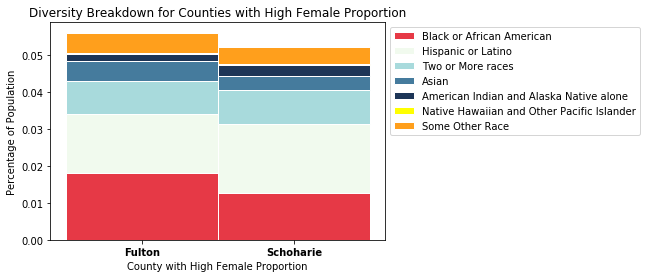

In [19]:
# Values of each group
#WhitePopB =[Fulton.WhitePop.sum(), Schoharie.WhitePop.sum()]
BlackpopB = [Fulton.BlackPop.sum(), Schoharie.BlackPop.sum()]
HispanicPopB = [Fulton.HispanicPop.sum(), Schoharie.HispanicPop.sum()]
MultiPopB = [Fulton.MultiPop.sum(), Schoharie.MultiPop.sum()]
AsianpopB = [Fulton.AsianPop.sum(), Schoharie.AsianPop.sum()]
Amer_espopB = [Fulton.Amer_esPop.sum(), Schoharie.Amer_esPop.sum()]
HawaiPopB = [Fulton.HawaiPop.sum(), Schoharie.HawaiPop.sum()]
OtherPopB = [Fulton.OtherPop.sum(), Schoharie.OtherPop.sum()]

# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fulton','Schoharie']
barWidth = 1

# Heights of bars1 + bars2 (TO DO better)
BlackHisp = [Fulton.BlackPop.sum()+Fulton.HispanicPop.sum(),Schoharie.BlackPop.sum()+Schoharie.HispanicPop.sum()]
BlackHispMulti = [Fulton.MultiPop.sum()+Fulton.BlackPop.sum()+Fulton.HispanicPop.sum(),Schoharie.MultiPop.sum()+Schoharie.BlackPop.sum()+Schoharie.HispanicPop.sum()]
BlackHispMultiAsian = [Fulton.AsianPop.sum()+Fulton.MultiPop.sum()+Fulton.BlackPop.sum()+Fulton.HispanicPop.sum(),Schoharie.AsianPop.sum()+Schoharie.MultiPop.sum()+Schoharie.BlackPop.sum()+Schoharie.HispanicPop.sum()]
BlackHispMultiAsianAmer =[Fulton.Amer_esPop.sum()+Fulton.AsianPop.sum()+Fulton.MultiPop.sum()+Fulton.BlackPop.sum()+Fulton.HispanicPop.sum(),Schoharie.Amer_esPop.sum()+Schoharie.AsianPop.sum()+Schoharie.MultiPop.sum()+Schoharie.BlackPop.sum()+Schoharie.HispanicPop.sum()]
BlackHispMultiAsianAmerHaw =[Fulton.HawaiPop.sum()+Fulton.Amer_esPop.sum()+Fulton.AsianPop.sum()+Fulton.MultiPop.sum()+Fulton.BlackPop.sum()+Fulton.HispanicPop.sum(),Schoharie.HawaiPop.sum()+Schoharie.Amer_esPop.sum()+Schoharie.AsianPop.sum()+Schoharie.MultiPop.sum()+Schoharie.BlackPop.sum()+Schoharie.HispanicPop.sum()]


# Create bars
plt.bar(r, BlackpopB,  color='#E63946', edgecolor='white', width=barWidth,label="Black or African American")
plt.bar(r, HispanicPopB, bottom=BlackpopB, color='#F1FAEE', edgecolor='white', width=barWidth,label="Hispanic or Latino")
plt.bar(r, MultiPopB, bottom = BlackHisp, color='#A8DADC', edgecolor='white', width=barWidth,label="Two or More races")
plt.bar(r, AsianpopB, bottom = BlackHispMulti, color='#457B9D',edgecolor='white', width=barWidth,label="Asian")
plt.bar(r, Amer_espopB, bottom=BlackHispMultiAsian, color='#1D3557', edgecolor='white', width=barWidth,label="American Indian and Alaska Native alone")
plt.bar(r, HawaiPopB, bottom = BlackHispMultiAsianAmer, color='yellow', edgecolor='white', width=barWidth,label="Native Hawaiian and Other Pacific Islander")
plt.bar(r, OtherPopB,bottom = BlackHispMultiAsianAmerHaw , color='#FF9F1C',edgecolor='white', width=barWidth,label="Some Other Race")


# Custom X axis
plt.xticks(r, names, fontweight='bold')
plt.title("Diversity Breakdown for Counties with High Female Proportion")
plt.ylabel("Percentage of Population")
plt.xlabel("County with High Female Proportion")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

pylab.savefig('Demographics.png',bbox_inches='tight')